## Considera√ß√µes Iniciais

Treinar modelos que envolvam t√©cnicas de Deep Learning e detec√ß√£o de imagens geralmente necessitam de uma grande quantia de dados para realizar predi√ß√µes precisas e construir modelos robustos.

√â importante tamb√©m frisarmos que, para os requisitos propostos queremos realizar a tarefa de **Detec√ß√£o de Objetos**, que difere da tarefa de **Classifica√ß√£o de Imagens** uma vez que essa segunda n√£o se preocupa em encontrar o objeto na imagem (por meio de *bounding box* por exemplo), mas sim informar que imagem √© de determinada classe.

Um algoritmo bastante utilizado para tarefas de detec√ß√£o de objeto em imagens √© o algoritmo YOLO, este utiliza da l√≥gica de encadeamento de CNNs (Redes Neurais Convolucionais) para realizar tarefas de vis√£o computacional. Al√©m disso o YOLO √© um modelo j√° treinado em uma enorme base de imagens, fazendo com que ele generalize muito bem a tarefa de detec√ß√£o.

Foram pesquisados tamb√©m outros algoritmos como MobileNet, ResNet, etc. Por√©m estes apresentam resultados e arquiteturas mais simples que exercem bem em tarefas de classifica√ß√£o, em que o YOLO apresenta um patamar de estado-da-arte quando o assunto √© detec√ß√£o.

Com as informa√ß√µes ditas acima, para o objetivo do projeto podemos utilizar o modelo YOLO e reaproveitar seus pesos, realizando um processo de Fine-tuning, ou seja iremos ajust√°-lo ao nosso dataset de imagens de fuma√ßa repassado. A utiliza√ß√£o do YOLO √© bem simples e amig√°vel com o pacote `ultralytics`, e a sua vers√£o mais nova √© a vers√£o 11, que ser√° utilizada para este projeto.



In [ ]:
# !pip install ultralytics
# !pip install opencv-python

Os pr√≥ximos passos s√£o necess√°rios para carregar todos os scripts para o google colab

In [1]:
!git clone https://github.com/renneruan/desafio-data-science-2025.git

Cloning into 'desafio-data-science-2025'...
remote: Enumerating objects: 3277, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 3277 (delta 10), reused 44 (delta 6), pack-reused 3228 (from 1)
Receiving objects: 100% (3277/3277), 133.29 MiB | 20.24 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (4642/4642), done.


In [3]:
%cd desafio-data-science-2025/

/content/desafio-data-science-2025


Descomentar em troca de ambiente, instala as depend√™ncias necess√°rias

In [6]:
# !pip install -r requirements.txt

In [1]:
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from ultralytics import YOLO
from smoke_detection.utils.commons import get_latest_folder

## Coleta das Imagens



Com a utiliza√ß√£o do YOLO em mente, precisamos de um dataset que possua imagens e suas correspond√™ncias de fuma√ßa/fogo em bounding box, iniciei a busca de imagens que possam se aproximar das desejadas na biblioteca de imagens https://universe.roboflow.com/.

O objetivo na cole√ß√£o era encontrar um dataset de imagens possivelmente tiradas por c√¢meras em torres, como n√£o temos essa informa√ß√£o f√°cil, escolhemos um dataset que:
- A fuma√ßa/fogo n√£o estivesse t√£o pr√≥ximo da c√¢mera;
- Pudessemos tra√ßar uma linha do horizonte definida;
- Sem imagens de drone, sat√©lite ou demais vistas a√©reas.
- Neste primeiro momento evitei tamb√©m datasets com muitas imagens direcionadas para a chama.

Foi utilizada as palavras chaves: *wildfire smoke detection forest fire*.

Um dataset que atendeu as especifica√ß√µes foi o:
https://universe.roboflow.com/tristandeeplearnnig/wildfire-smoke-detection-v7bqc

√â poss√≠vel realizar o download do dataset utilizando o snippet de c√≥digo abaixo, por√©m para garantir a disponibiliza√ß√£o e evitar a necessidade de cadastro para recuperar a API key, ele tamb√©m foi baixado em zip e salvo no reposit√≥rio Git (apenas para car√°ter de projeto, dados de produ√ß√£o podem ser sens√≠veis e n√£o devem ser salvos em Git).

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="_")
# project = rf.workspace("tristandeeplearnnig").project("wildfire-smoke-detection-v7bqc")
# version = project.version(1)
# dataset = version.download("yolov11")


Observa√ß√µes: Por utilizar um dataset baixado de terceiro, a n√£o ser que verifiquemos imagem por imagem n√£o podemos garantir a qualidade da rotula√ß√£o e cria√ß√£o dos bounding boxes, al√©m de garantir a total falta de Data Leakege por exemplo. A biblioteca YOLO n√£o apresenta fun√ß√µes nativas para verificar em grande escala essa designa√ß√£o. Na pr√≥xima se√ß√£o irei verificar o perfil do bounding box de uma pequena amostra das imagens baixadas.

Temos como quantia:
- Treino: 1.378
- Valida√ß√£o: 147
- Teste: 74

Propor√ß√µes aproximadas: 85% 10% 5%

O dataset apresenta apenas uma classe: Smoke

## Verificar o perfil das imagens

Irei realizar uma verifica√ß√£o manual do perfil da rotulagem e das imagens, para isso irei gerar as imagens com as informa√ß√µes de Bounding Box em uma pasta a parte, onde podemos visualizar se as Bounding Box criadas est√£o correspondentes a √°rea de fuma√ßa.

Para manter este notebook enxuto, criei as fun√ß√µes auxiliares para ler o arquivo YAML de caminho dos dados e criar as imagens com as bounding box nos arquivos `src/smoke_detection/utils/commons.py` e `src/smoke_detection/utils/image_evaluation.py` respectivamente.

In [ ]:
from smoke_detection.utils.commons import read_yaml
from smoke_detection.utils.image_evaluation import iterate_images_and_labels

# Define os caminhos que ser√£o utilizados
all_datasets_path = "../datasets/"
dataset_name = "data/"
processed_dataset_name = "processed_data/"
dataset_path = os.path.join(all_datasets_path, dataset_name)
processed_dataset_path = os.path.join(all_datasets_path, processed_dataset_name)


data_file_path = os.path.join(dataset_path, "data.yaml")
processed_data_file_path = os.path.join(processed_dataset_path, "data.yaml")

# Caminho para as imagens de avalia√ß√£o manual
path_file = read_yaml(data_file_path)

[2025-02-24 07:16:58,085: INFO: commons: Arquivo yaml: ../datasets/data/data.yaml carregado com sucesso.]


In [ ]:
# Cria as imagens para avalia√ß√£o manual e retorna as labels correspondentes
# Irei fazer isso para verificar se existe alguma imagem sem classifica√ß√£o
# ou com classifica√ß√£o diferente de fuma√ßa
images_with_bb_path = os.path.join(dataset_path, "manual_evaluation")

labels = iterate_images_and_labels(
    os.path.join(dataset_path, path_file["train"]),
    images_with_bb_path
)

[2025-02-24 07:17:24,425: INFO: image_evaluation: Imagens para avalia√ß√£o visual criadas.]


Com as imagens geradas na pasta `datasets/data/manual_evaluation` foi poss√≠vel perceber algumas caracter√≠sticas do conjunto de dados utilizado:

- H√° a presen√ßa de muitas imagens repetidas, por exemplo 2 imagens id√™nticas ou quase id√™nticas para o mesmo foco de fuma√ßa; Podemos posteriormente elencar formas de identificar essas duplicidades e excluir dos nossos dados de treino.
- As imagens j√° est√£o no tamanho 640x640, tamanho esperado para aplica√ß√£o ao YOLO;
- Algumas imagens j√° apresentam uma c√≥pia em flip horizontal, esta poderia ser uma etapa do pr√©-processamento, uma vez que pegamos a imagem e invertemos horizontalmente para que o modelo possa assimilar caracter√≠sticas da fuma√ßa tanto crescente para o lado direito como para o esquerdo. Este comportamento levanta a d√∫vida se essa etapa de pr√©-processamento segue necess√°ria.

Al√©m disso os labels contidos nos arquivos de r√≥tulo YOLO foram salvos para serem retornados.

In [5]:
# Exemplo de array com objetos (dtype=object)
labels = np.array(labels, dtype=object)
none_elements = labels[labels == None]
none_elements

array([], dtype=object)

Vemos que todas as imagens apresentam uma Bounding Box, ou seja, n√£o h√° imagens que nos traga a informa√ß√£o apenas de background, em outras condi√ß√µes pode ser interessante adicionar imagens que n√£o possuam o objeto a ser detectado para um melhor treinamento do modelo.

A t√≠tulo de exemplifica√ß√£o vamos coletar aleatoriamente algumas imagens do conjunto de treino (com a Bounding Box desenhada).

In [22]:
image_files = [f for f in os.listdir(os.path.join(dataset_path, path_file["train"])) if f.endswith(('.jpg'))]
random_images = random.sample(image_files, 5)
random_images

['ck0u10zeh74ym0848ow29lc1l_jpeg_jpg.rf.36c6ab3c88a793aa5919d2ea7ae970ac.jpg',
 'ck0kd70pu4w7b07946742zfpg_jpeg_jpg.rf.5fc10059c722d5ac11b2b1eef0d9c52c.jpg',
 'ck0tzw6en6xyw0848myghrsxc_jpeg_jpg.rf.9360d41135418663b439f30ee541626a.jpg',
 'ck0na5s461w2n0794ifd5c5cs_jpeg_jpg.rf.10a46f4f32a7d4659311a1f04c873a9c.jpg',
 'ck0ndwu8pj3180848zonjasmz_jpeg_jpg.rf.011f40a3425629283047cbcaf73bfb8d.jpg']

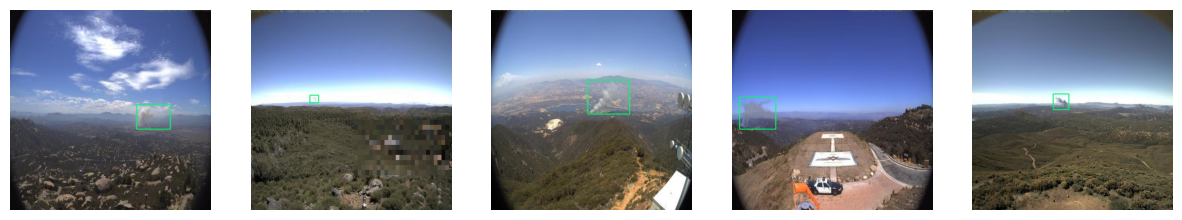

In [7]:
def print_images_in_row(path, images_list):
    plt.figure(figsize=(15, 12))
    for i, img_name in enumerate(images_list):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)

        # OpenCV l√™ a imagem como BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        # plt.title(img_name)

    plt.show()

print_images_in_row(images_with_bb_path, random_images)


Essa amostra j√° no mostra v√°rias diferen√ßas entre as imagens como em n√≠vel de brilho, escala de cores e satura√ß√£o, al√©m da poss√≠vel presen√ßa por exemplo de objetos.

## Pr√©-processamento


Para a etapa de pr√©-processamento podemos realizar as seguintes opera√ß√µes:

- Normaliza√ß√£o da imagem (Adequar os valores para 0 a 1)
- Aplica√ß√£o de data augmentation, ou seja, criar imagens rotacionadas, espelhadas e com fuma√ßa fora do centro.
- Transforma√ß√£o para escala de cinza ou outras escalas como HSV
- Redu√ß√£o de ru√≠dos

Foi verificado que o algoritmo YOLOv11 j√° realiza o processo de normaliza√ß√£o dos dados, colocando-os numa escala de 0 a 1 automaticamente (https://docs.ultralytics.com/pt/guides/preprocessing_annotated_data). Devido a isso iremos pular essa etapa, por√©m para realiz√°-la bastaria subtrairmos os valores de pixel dos canais de cor por 255.

Al√©m disso como comentado na se√ß√£o anterior, o dataset obtido j√° possui diversas imagens duplicadas e rotacionadas horizontalmente, como estamos lidando com imagens de torres e elas partem do princ√≠pio de imagens com a linha do horizonte bem definida, inicialmente talvez n√£o fizesse sentido termos imagens rotacionadas 90¬∫ por exemplo. Ou seja, o dataset baixado j√° teve etapas de data augmentation realizadas.

As imagens do dataset apresentam uma grande variabilidade de brilho, constrastes e cores, vamos aplicar uma equaliza√ß√£o no plano HSV, com isso conseguimos alterar apenas a banda Value, mantendo a caracter√≠stica de cores muito importante para a classifica√ß√£o das fuma√ßas com o elementos do fundo. 

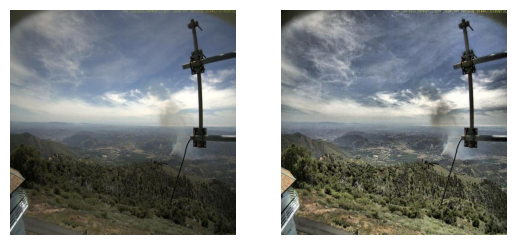

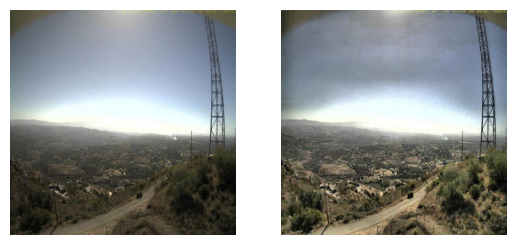

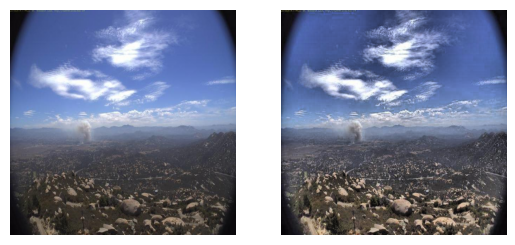

In [28]:
def equalize_brightness_hsv(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)    

    h, s, v = cv2.split(hsv)

    # CLAHE significa "Contrast Limited Adaptive Histogram Equalization"
    # Processa o contraste das imagens realizando uma equaliza√ß√£o
    # Deixa √°reas escuras mais claras e √°reas muito claras mais escuras
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Aplicamos a equaliza√ß√£o apenas no canal Value mantendo a cor e a satura√ß√£o
    v_eq = clahe.apply(v) 

    hsv_eq = cv2.merge((h, s, v_eq))
    img = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB) 

    return  img


example_images = [
    "ck0l9dfokcv7o07013t4kgamc_jpeg_jpg.rf.9c22946250a37ecfe213aba471bdb11a.jpg",
    "ck0kd8vmh68nl083835g4ngoc_jpeg_jpg.rf.3d8eea8828718e2e598d9f0e51092497.jpg",
    "ck0lwgsmatsrm0848br00vfki_jpeg_jpg.rf.02a4da7dc56668267c63121528f8c8c5.jpg"
]

for image in example_images:
    teste = os.path.join(dataset_path, path_file["train"], image)
    image = cv2.imread(teste)

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    normalized = equalize_brightness_hsv(image) # Aplica brilho

    plt.subplot(1, 2, 2)
    plt.imshow(normalized)
    plt.axis("off")
    plt.show()

As imagens anteriores foram escolhidas a t√≠tulo de exemplifica√ß√£o, podemos perceber um maior destaque dos casos de fuma√ßa, e uma melhor visualiza√ß√£o das imagens no geral.



Seria poss√≠vel visualizar alguns artigos cient√≠ficos que realizam procedimentos em imagens para melhor escolher t√©cnicas que se adequam ao nosso caso, temos algos um exemplo de refer√™ncias:

https://www.sciencedirect.com/science/article/abs/pii/S1290072902013972 \
https://www.mdpi.com/2073-8994/12/7/1075 \
https://www.mdpi.com/1999-4907/15/5/839 

Vamos realizar esse procedimento em todas as imagens do dataset para treino e valida√ß√£o.

In [39]:
train_processed = os.path.join(processed_dataset_path, path_file["train"])

os.makedirs(train_processed, exist_ok=True)
for image in image_files:
    train_image = os.path.join(dataset_path, path_file["train"], image)
    image_object = cv2.imread(train_image)
    normalized = equalize_brightness_hsv(cv2.cvtColor(image_object, cv2.COLOR_BGR2RGB))

    cv2.imwrite(os.path.join(train_processed, image), normalized)

In [43]:
val_processed = os.path.join(processed_dataset_path, path_file["val"])
val_image_files = [f for f in os.listdir(os.path.join(dataset_path, path_file["val"])) if f.endswith(('.jpg'))]


os.makedirs(val_processed, exist_ok=True)
for image in val_image_files:
    val_image = os.path.join(dataset_path, path_file["val"], image)
    image_object = cv2.imread(val_image)
    normalized = equalize_brightness_hsv(cv2.cvtColor(image_object, cv2.COLOR_BGR2RGB))

    cv2.imwrite(os.path.join(val_processed, image), normalized)

## Treinamento do Modelo

Nesta etapa iremos inserir nossas imagens de treino ao modelo YOLOv11 para realizar o Fine-tuning do mesmo a nossa tarefa de detec√ß√£o de fuma√ßa.

Como foi utilizado o Google Colab, o treinamento foi realizado em 15 √©pocas. Com um batch de 100, o que consumia aproximadamente 14 GB de GPU

In [44]:
model = YOLO("yolo11n.pt") # pt para modelo pr√©-treinado

# Treina o modelo no conjunto train da pasta data
# imgsz j√° tem como valor padr√£o 640
model.train(
    data=os.path.abspath(processed_data_file_path),
    epochs=15,
    batch=100,
    device=0, # 0 para GPU, -1 para CPU
    seed=42
)

print("Treinamento finalizado.")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5.35M/5.35M [00:00<00:00, 9.79MB/s]


NameError: name 'processed_data_file_path' is not defined

Vamos salvar o resultado do melhor modelo `best.pt` na pasta `artifacts/model`. Isso ser√° feito para podermos utilizar esse objeto posteriormente para a predi√ß√£o. Esse passo deve ser rodado antes do eval, uma vez que este ir√° criar uma nova pasta com os resultados de avalia√ß√£o.

In [ ]:
# Resgata o resultado do √∫ltimo treinamento
latest_folder = get_latest_folder(Path("runs/detect"))

best_model = os.path.join(latest_folder, "weights/best.pt")

print(best_model)
destination = "artifacts/model/best.pt"
if os.path.exists(best_model):
    shutil.move(best_model, destination)
    print("Arquivo de melhor modelo movido com sucesso.")
else:
    print("O arquivo n√£o foi encontrado.")

runs/detect/train2/weights/best.pt
Arquivo de melhor modelo movido com sucesso.


## Avalia√ß√£o do modelo

A chamada para o m√©todo `model.val()` retorna a avalia√ß√£o do modelo nas imagens presentes na pasta `valid` do dataset, ou seja, nosso conjunto de teste, com isso podemos acessar imagens contendo gr√°ficos de m√©tricas para an√°lise posterior.

In [19]:
# Avalia no conjunto de valida√ß√£o (valid)
metrics = model.val()

Ultralytics 8.3.78 üöÄ Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/desafio-data-science-2025/datasets/data/valid/labels.cache... 147 images, 0 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 147/147 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:05<00:00,  2.58s/it]


                   all        147        147      0.838       0.85      0.904      0.534
Speed: 6.2ms preprocess, 4.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train22



O modelo YOLO possui como resultado as seguintes m√©tricas para a dete√ß√£o de "objetos" em imagens:

In [20]:
metrics.results_dict

{'metrics/precision(B)': 0.8383723636946852,
 'metrics/recall(B)': 0.8503401360544217,
 'metrics/mAP50(B)': 0.9038915860524149,
 'metrics/mAP50-95(B)': 0.5341664420036911,
 'fitness': 0.5711389564085635}

A partir da [documenta√ß√£o de m√©tricas](https://docs.ultralytics.com/guides/yolo-performance-metrics/#choosing-the-right-metrics) referente ao YOLO, temos a seguinte explica√ß√£o para as m√©tricas de classe mostradas anteriormente:

- Precision: A acur√°cia de quantas detec√ß√µes foram corretas.
- Recall A habilidade do modelo em detectar todas as inst√¢ncias do objeto em imagens, nesse caso fuma√ßa.
- mAP50: Mede a precis√£o m√©dia das detec√ß√µes do modelo considerando um limiar de IoU (Intersection over Union, ou seja o bounding box predito com o verdadeiro) de 50%.
- mAP50-95: Semelhante a m√©trica anterior por√©m fornecendo um limiar vari√°vel, avaliando o modelo em detec√ß√µes mais dif√≠ceis, importante para casos em que a precis√£o √© essencial.
- A m√©trica fitness √© uma m√©trica composta para medir o desempenho do modelo de forma geral.

A seguir temos as m√©tricas de velocidade:

In [21]:
metrics.speed

{'preprocess': 6.190585578231233,
 'inference': 4.5451745510209065,
 'loss': 0.00015059863920393834,
 'postprocess': 2.260242850340336}

Temos como m√©trica de tempo principal o valor de ms necess√°rio para a a√ß√£o de infer√™ncia de uma √∫nica imagem.

Podemos visualizar tamb√©m os gr√°ficos de m√©trica gerados pelo m√©todo val.


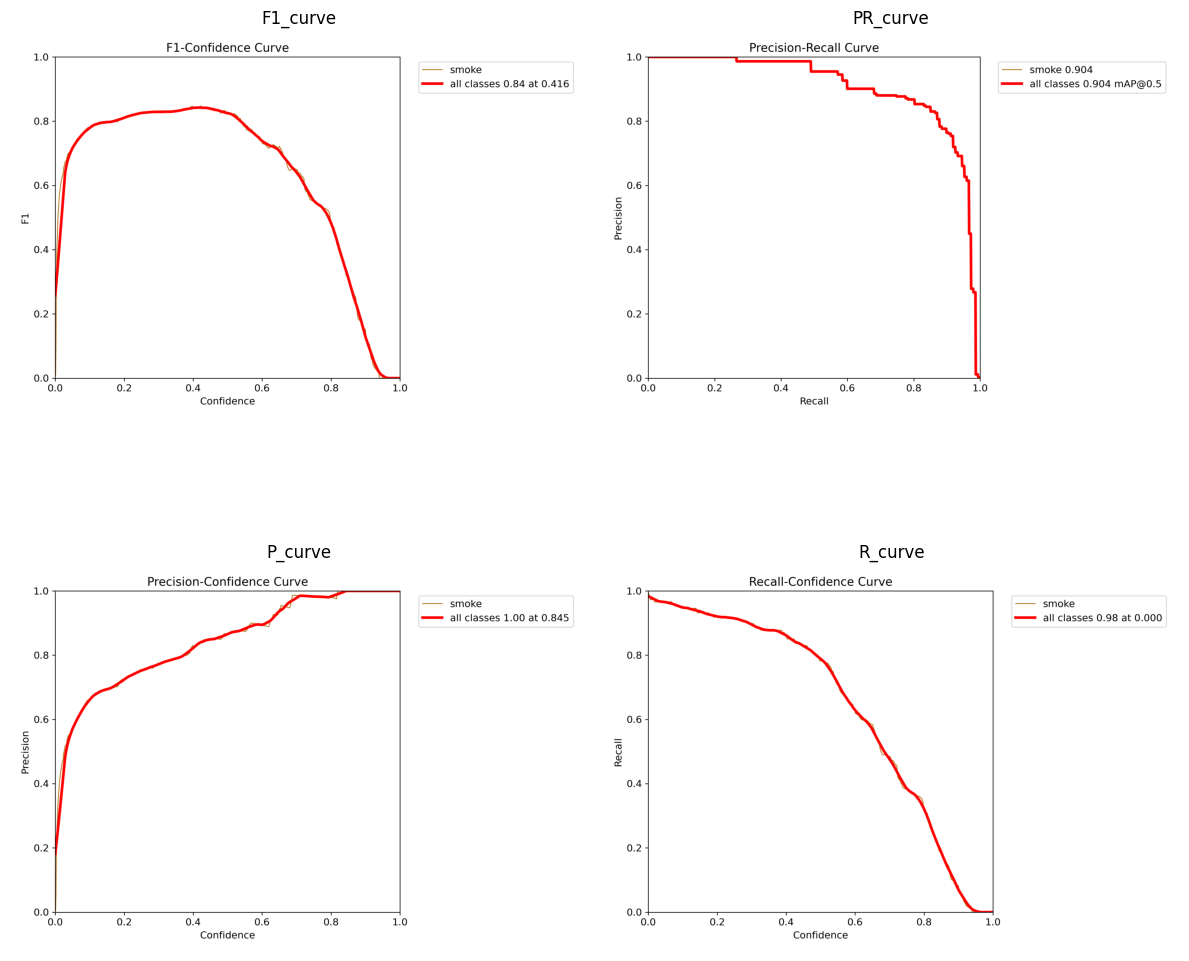

In [23]:
latest_folder = get_latest_folder(Path("runs/detect"))

graphs = [
    "F1_curve",
    "PR_curve",
    "P_curve",
    "R_curve"
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, graph_name in enumerate(graphs):
    img_path = Path(os.path.join(latest_folder, f"{graph_name}.png"))
    if img_path.exists():
        img = cv2.imread(img_path)

        ax = axes[i // 2, i % 2]
        ax.imshow(img)
        ax.set_title(graph_name)
        ax.axis("off")

plt.tight_layout()
plt.show()


Temos:
- A curva F1, em que o F1-Score se trata da m√©dia harm√≥nica da precis√£o e da revoca√ß√£o (recall), para a curva temos este valor para diferentes limiares de confian√ßa, visualizamos que na medida que a confian√ßa aumenta a m√©trica de F1 tende a abaixar. Em um limiar m√©dio de 0.5 temos um F1 Score acima de 0.8.
- A curva de Precision e Recall, no geral essa curva √© importante para lidar com problema de desbalanceamento quando h√° a exist√™ncia de m√∫ltiplas classes, podemos a partir dela analisa o trade off entre as duas m√©tricas.
- Curva de Precis√£o e Confian√ßa, semelhante a primeira curva por√©m apenas para precis√£o.
- Curva de Recall e Confian√ßa, semelhante a primeira curva por√©m apenas para revoca√ß√£o.

Podemos verificar tamb√©m as matrizes de confus√£o geradas, como s√≥ temos apenas uma classe, a matriz de confus√£o possui apenas os valores de fuma√ßa e background (classe gerada automaticamente).   

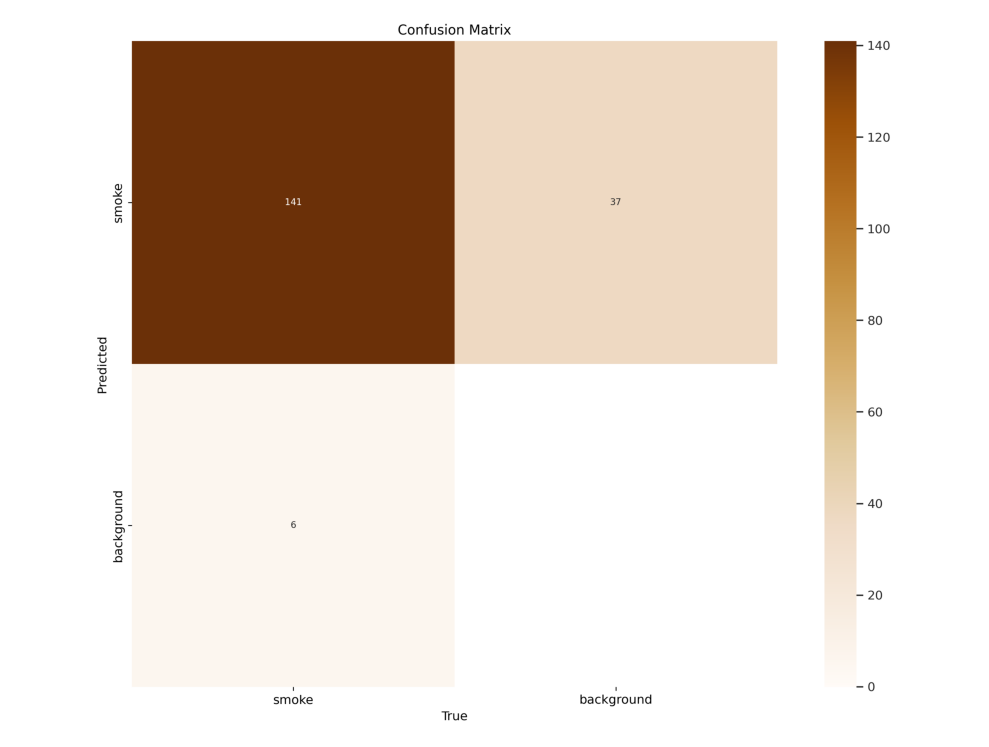

In [24]:
plt.figure(figsize=(10, 10))
img_path = Path(os.path.join(latest_folder, "confusion_matrix.png"))
if img_path.exists():
    img = cv2.imread(img_path)

    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


Temos a predomin√¢ncia de falsos positivos do que falsos negativos, considerando o o caso de fogo em floresta queremos reduzir ao m√°ximo os casos de falsos negativos, uma vez que deixar a incid√™ncia do fogo se alastrar √© o pior cen√°rio, enquanto o falso positivo pode ser verificado e validado por um agente humano antes de ser tomada qualquer a√ß√£o.

## Predi√ß√£o em imagens de teste

In [25]:
test_image_files = [f for f in os.listdir(os.path.join(dataset_path, path_file["test"])) if f.endswith(('.jpg'))]
random_test_images = random.sample(test_image_files, 5)
random_test_images

['ck0khrg9xan7u0721mn5rxpzo_jpeg_jpg.rf.030755fa9e22c118cbe345919d196619.jpg',
 'ck0nepj3s015b0a88py3wvbqu_jpeg_jpg.rf.de3b938218e0a09a065def9a4ad2950b.jpg',
 'ck0kosu846k350794gya7bot0_jpeg_jpg.rf.4d1e5515c244ea76b84bf2b45334e9c8.jpg',
 'ck0m1n0c1hbus0863ti6kd58t_jpeg_jpg.rf.eb93fb80590669f5f0156aebed417cbc.jpg',
 'ck0nftcfgka7e0848a9ie2b3b_jpeg_jpg.rf.792243de554062c1def618b87c5bad5d.jpg']

Vamos realizar a infer√™ncia em m√∫ltiplas imagens de teste.

In [32]:
results = {}
for image in random_test_images:
    test_image = os.path.join(
        dataset_path,
        path_file["test"],
        image
    )

    results[test_image] =  model(test_image)

print(results)


image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0khrg9xan7u0721mn5rxpzo_jpeg_jpg.rf.030755fa9e22c118cbe345919d196619.jpg: 640x640 1 smoke, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0nepj3s015b0a88py3wvbqu_jpeg_jpg.rf.de3b938218e0a09a065def9a4ad2950b.jpg: 640x640 1 smoke, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0kosu846k350794gya7bot0_jpeg_jpg.rf.4d1e5515c244ea76b84bf2b45334e9c8.jpg: 640x640 2 smokes, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0m1n0c1hbus0863ti6kd58t_jpeg_jpg.rf.eb93fb80590669f5f0156aebed417cbc.jpg: 640x640 1 smoke, 8.2ms
Speed: 1.7ms preprocess

Com os resultados j√° obtidos agora necessitamos amostr√°-las graficamente.

datasets/data/test/images/ck0khrg9xan7u0721mn5rxpzo_jpeg_jpg.rf.030755fa9e22c118cbe345919d196619.jpg
datasets/data/test/images/ck0nepj3s015b0a88py3wvbqu_jpeg_jpg.rf.de3b938218e0a09a065def9a4ad2950b.jpg
datasets/data/test/images/ck0kosu846k350794gya7bot0_jpeg_jpg.rf.4d1e5515c244ea76b84bf2b45334e9c8.jpg
datasets/data/test/images/ck0m1n0c1hbus0863ti6kd58t_jpeg_jpg.rf.eb93fb80590669f5f0156aebed417cbc.jpg
datasets/data/test/images/ck0nftcfgka7e0848a9ie2b3b_jpeg_jpg.rf.792243de554062c1def618b87c5bad5d.jpg


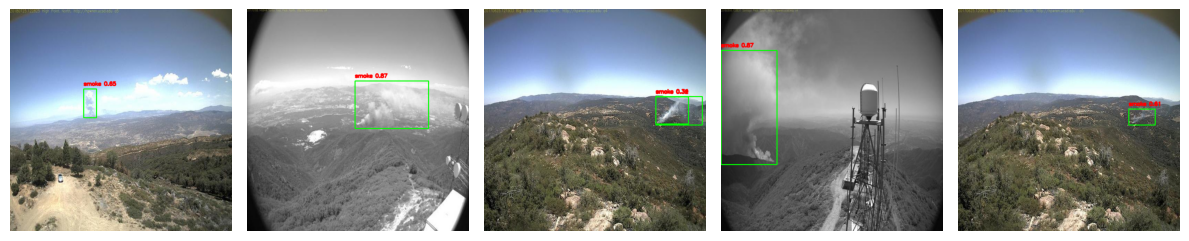

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12, 12))

for i, (image_path, image_results) in enumerate(results.items()):
  print(image_path)
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  for result in image_results:
    boxes = result.boxes
    for box in boxes:
      x1, y1, x2, y2 = map(int, box.xyxy[0])

      # Score de confian√ßa
      conf = float(box.conf[0])

      # Classe de fuma√ßa (smoke)
      cls = int(box.cls[0])
      label = f"{model.names[cls]} {conf:.2f}"

      # Preenche o Bounding Box e o valor de Confian√ßa
      img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
      img = cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255, 0, 0), 2, cv2.LINE_AA)

  ax = axes[i]
  ax.imshow(img)
  # ax.set_title(f"Imagem {i+1}")
  ax.axis("off")

plt.tight_layout()
plt.show()


O pr√≥ximo passo √© essencial em Google Colab para baixar novamente o projeto executado.

In [37]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
# !zip -r /content/project.zip /content/

# from google.colab import files
# files.download('/content/project.zip')

A sa√≠da de streaming foi truncada nas √∫ltimas 5000 linhas.
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0nfrec983h90701yvzbsczw_jpeg_jpg.rf.4640b92ea4bc613b967e7b9a9abc2bbe.jpg (deflated 2%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0kkv2jf8pil09448qnz1ndu_jpeg_jpg.rf.3ef6e8b98204687a0fc6864764c6099b.jpg (deflated 4%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0qd6v51ib0j0701sf2wolfq_jpeg_jpg.rf.d75f1f96935d0073fec4b0745983301b.jpg (deflated 1%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0u0i88bunv00944unevdbqg_jpeg_jpg.rf.78af7862c52d1abe137de8103da5ee99.jpg (deflated 3%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0kmh9hhkg5e0a46we9ywaxl_jpeg_jpg.rf.5f963cba97837863db5fc31786490b83.jpg (deflated 2%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0neh5qnjfoh0848s35xyyj8_jpeg_jpg.rf.92a835e63feca310211add438fd4cc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>